<a href="https://colab.research.google.com/github/ttya16/ImageClassifier/blob/master/ImageClassifier_using_tf(keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ImageDataGeneratorを用いた画像分類モデル

kerasのImageDataGeneratorを用いて、ネットから検索した画像の分類モデル
<br>


画像収集はGoogleAPIを用いた方法で行った。
[参考記事]("https://qiita.com/onlyzs/items/c56fb76ce43e45c12339")



In [0]:
import urllib.request
from urllib.parse import quote
import httplib2
import json 
import os

GoogleAPI key

In [0]:
API_KEY = "Your API key"
CUSTOM_SEARCH_ENGINE = "Your custom search engine"

訓練用画像データファイルを格納するフォルダを作成

In [0]:
!mkdir train
!mkdir train/sunny
!mkdir train/rain
!mkdir valid
!mkdir valid/sunny
!mkdir valid/rain



In [0]:
def get_image_url(search_item, total_num):
    img_list = []
    i = 0
    while i < total_num:
        query_img = "https://www.googleapis.com/customsearch/v1?key=" + API_KEY + "&cx=" + CUSTOM_SEARCH_ENGINE + "&num=" + str(10 if(total_num-i)>10 else (total_num-i)) + "&start=" + str(i+1) + "&q=" + quote(search_item) + "&searchType=image"
        print (query_img)
        res = urllib.request.urlopen(query_img)
        data = json.loads(res.read().decode('utf-8'))
        for j in range(len(data["items"])):
            img_list.append(data["items"][j]["link"])
        i=i+10
    return img_list

def get_image(search_item, img_list, dir_name="any", validation_rate = 0.2):
    opener = urllib.request.build_opener()
    http = httplib2.Http(".cache")
    
    valid_id =int(len(img_list)*(1 - validation_rate))
    
    for i in range(len(img_list)):
        try:
            fn, ext = os.path.splitext(img_list[i])
            print(img_list[i])
            response, content = http.request(img_list[i])
            if i < valid_id:
              with open("train/"+dir_name+ "/"+search_item+str(i)+".png", 'wb') as f:
                  f.write(content)
                  
            else:
              with open("valid/"+dir_name+ "/"+search_item+str(i)+".png", 'wb') as f:
                  f.write(content)
              
        except:
            print("failed to download the image.")
            continue
            
            
            
            

In [0]:
#検索ワードと収集する画像数を指定して用意したディレクトリへ保存する。
img_list_sunny = get_image_url("sunny sky photo", 80)
get_image("sunny", img_list_sunny, dir_name='sunny')

In [0]:
img_list_rain = get_image_url("rainy　sky photo", 80)
get_image("rain", img_list_rain, dir_name='rain')

In [0]:
#バッチの大きさ。

nb_batch_size = 16

# 内部処理するイメージの大きさ。値は自由だがVGG16を使うので48以上の値にする。
# チャンネル数はRGB3色なので3だが、いずれにせよVGG16を使う以上ここは3固定
# 詳細はKerasのマニュアルを参照 https://keras.io/ja/applications/#vgg16

img_w, img_h = 224,224
channels = 3

# 学習に使うイメージの総数を単位として、1エポックでどれだけのイメージを使って学習するかを指定する。

nb_train_step_per_epoch = 8

# エポックの数

nb_epoch = 30

#クラスの数
nb_classes = 2

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   horizontal_flip= True, 
                                   vertical_flip= True, 
                                   rotation_range=90, 
                                   shear_range=5,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.3,
                                   channel_shift_range=3.,
                                   brightness_range=[0.4, 1.0],
                                   fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255, 
                                        horizontal_flip= True, 
                                        vertical_flip= True, 
                                        rotation_range=90, 
                                        shear_range=5,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,
                                        zoom_range=0.3,
                                        channel_shift_range=3.,
                                        brightness_range=[0.4, 1.0],
                                        fill_mode = 'nearest')

train_dir = "/content/train"
valid_dir = "/content/valid"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_w, img_h),
    batch_size=nb_batch_size,
    color_mode = 'rgb')

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_w, img_h),
    batch_size=nb_batch_size,
    color_mode = 'rgb')

Found 122 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [0]:
#VGG16 transfer learning

import keras

input_tensor = keras.layers.Input(shape=(img_w, img_h, 3))
model_feature = keras.applications.vgg16.VGG16(
                  include_top=False, 
                  weights='imagenet', 
                  input_tensor=input_tensor)

# 転移学習をするときには、畳込み層を全てフリーズする
for layer in model_feature.layers:
    layer.trainable = False
    
model_feature.output_shape

(None, 7, 7, 512)

In [0]:

# パーセプトロン部の作成
model_perceptron = keras.models.Sequential()
model_perceptron.add(keras.layers.Flatten(input_shape=model_feature.output_shape[1:]))
model_perceptron.add(keras.layers.Dense(512, activation='relu'))
model_perceptron.add(keras.layers.BatchNormalization())
model_perceptron.add(keras.layers.Dropout(0.2))
model_perceptron.add(keras.layers.Dense(256, activation='relu'))
model_perceptron.add(keras.layers.BatchNormalization())
model_perceptron.add(keras.layers.Dropout(0.2))
model_perceptron.add(keras.layers.Dense(64, activation='relu'))
model_perceptron.add(keras.layers.BatchNormalization())
model_perceptron.add(keras.layers.Dropout(0.2))
model_perceptron.add(keras.layers.Dense(
                      nb_classes, 
                      activation='sigmoid'))


# VGG16とパーセプトロンを接続する
model = keras.models.Model(inputs=model_feature.input, outputs=model_perceptron(model_feature.output))

# コンパイル
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.adam(lr=1e-3),
              metrics=['accuracy'])



In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Training

In [0]:
# Fine-tuning
history = model.fit_generator(
      train_generator,
      steps_per_epoch= nb_train_step_per_epoch * len(train_generator),  
      epochs=nb_epoch,
      verbose=1,
      validation_data = validation_generator,
      validation_steps = 8
)

model.save("vgg16_transfer_model.hdf5")
model.save_weights("weight_fine_tuning_"+str(nb_classes)+"classes.hdf5")


Epoch 1/30
64/64 [==============================] - 56s 875ms/step - loss: 0.4460 - acc: 0.7991 - val_loss: 0.4245 - val_acc: 0.8200
Epoch 2/30
64/64 [==============================] - 54s 836ms/step - loss: 0.2967 - acc: 0.8749 - val_loss: 0.6415 - val_acc: 0.7850
Epoch 3/30
64/64 [==============================] - 54s 840ms/step - loss: 0.2469 - acc: 0.9018 - val_loss: 0.6145 - val_acc: 0.8300
Epoch 4/30
64/64 [==============================] - 54s 843ms/step - loss: 0.2540 - acc: 0.9007 - val_loss: 0.2796 - val_acc: 0.8650
Epoch 5/30
64/64 [==============================] - 53s 834ms/step - loss: 0.2274 - acc: 0.9045 - val_loss: 1.3206 - val_acc: 0.6750
Epoch 6/30
64/64 [==============================] - 54s 846ms/step - loss: 0.2296 - acc: 0.9059 - val_loss: 0.6680 - val_acc: 0.7800
Epoch 7/30
64/64 [==============================] - 54s 843ms/step - loss: 0.2066 - acc: 0.9109 - val_loss: 1.0111 - val_acc: 0.7900
Epoch 8/30
64/64 [==============================] - 54s 845ms/step - 

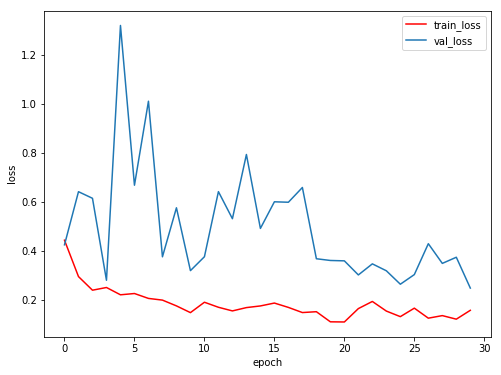

In [0]:
#plot loss history
fig = plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], color='r', label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.xlabel("epoch")
plt.ylabel("loss")


plt.show()

In [0]:
class_dict = train_generator.class_indices
inv_class_dict = {v:k for k, v in class_dict.items()}
print(inv_class_dict)

{0: 'rain', 1: 'sunny'}


Saving rainy4.jpeg to rainy4.jpeg


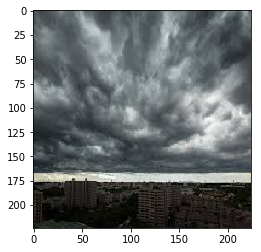

[1. 0.]


In [9]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import keras

import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(img_w, img_h))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = keras.applications.vgg16.preprocess_input(x)
  
  plt.imshow(img)
  plt.show()

  images = np.vstack([x])
  pred = model.predict(images, batch_size=10)
  print(pred[0])



(1, 224, 224, 3)
[1. 0.]
天気が悪そうですね。


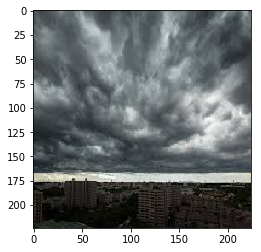

In [10]:
path = 'rainy4.jpeg'
test_img = image.load_img(path, target_size=(img_w, img_h))
plt.imshow(test_img)
test_x = image.img_to_array(test_img)
test_x = np.expand_dims(test_x, axis=0)
test_x = keras.applications.vgg16.preprocess_input(test_x)
print(test_x.shape)
pred_test = model.predict(test_x)[0]
print(pred_test)

result = [(inv_class_dict[i], pred_test[i]) for i in pred_test.argsort()]

if pred_test[0] > 0.5:
  if pred_test[0] > 0.9:
    print('天気が悪そうですね。')
    
  else:
    print('悪い天気ではなさそうですが、雲が多いように見えます。')
  
else:
  print('良い天気のように見えます。')